In [84]:
import joblib
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import os

from skbio.stats.composition import clr
from sklearn import model_selection, ensemble, metrics
import warnings
warnings.filterwarnings('ignore')

import fpdf
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})

import shared_functions
joblib_dir = 'joblib'
pic_dir = 'pics'

In [85]:
bf = joblib.load('joblib/catsNdogs_mw_bf.joblib')
data = joblib.load('joblib/catsNdogs_data.joblib')
dataset_info = joblib.load('joblib/catsNdogs_dataset_info.joblib')
print(dataset_info.Host_type.value_counts())

human    321
pet      321
Name: Host_type, dtype: int64


In [86]:
def test_parameters(X,y,name,param_pic_name,pdf):
    max_features = int(np.sqrt(X.shape[1]))+1
    param_grid = {'n_estimators': [100],
                  'max_depth': np.arange(2,13,1),
                  'min_samples_split': np.arange(2,11,1),
                  'max_features': np.arange(1,max_features+1)
                 }
#     param_grid = {'n_estimators': [100],
#                   'max_depth': np.arange(2,4,1),
#                   'min_samples_split': np.arange(2,4,1),
#                   'max_features': np.arange(1,4)
#                  }
    rf = ensemble.RandomForestClassifier(random_state=42)
    optimizer = model_selection.GridSearchCV(rf, param_grid, cv=5, n_jobs=4,return_train_score=True)
    optimizer.fit(X, y)
    best_score1 = optimizer.best_score_
    best_params1 = optimizer.best_params_
    print('Best score 1:',best_score1)
    print('Best parameters 1:',best_params1)
    param_grid_big = {'n_estimators': [1,5,10,50,100,500,1000],
                      'max_depth': np.arange(2,31,1),
                      'min_samples_split': np.arange(2,31,1),
                      'max_features': np.arange(1,X.shape[1]+1)
                     }
    best_params2 = {}
    n_cols = 2
    n_rows = int(np.ceil((len(best_params1))/n_cols))
    fig, axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*3.3,n_rows*3.3),sharey=True)
    #fig.suptitle('Model: '+name)
    plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
    i = 0
    j = 0
    for k1,v1 in best_params1.items():
        k_dict = {}
        for k,v in best_params1.items():
            if (k==k1):
                k_dict[k]=param_grid_big[k]
               # k_dict[k]=param_grid[k]
            else:
                k_dict[k] = [best_params1[k]]
        rf = ensemble.RandomForestClassifier(random_state=42)
        optimizer = model_selection.GridSearchCV(rf, k_dict, cv=5, n_jobs=4,return_train_score=True)
        optimizer.fit(X, y)
        best_params2[k1] = optimizer.best_params_[k1]
        if (k1 in ['n_estimators','min_impurity_decrease']):
            plot_scores(optimizer,k1,axs[i][j],log=True)
            axs[i][j].title.set_text(k1)
        else:
            plot_scores(optimizer,k1,axs[i][j],log=False)
            axs[i][j].title.set_text(k1)
        j = j + 1
        if (j==axs.shape[1]):
            i = i + 1
            j = 0
    if (best_params2['n_estimators']) < 100:
        best_params2['n_estimators']=100
    #plt.show()
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(b=None)
    #plt.xlabel("common X")
    plt.ylabel("Accuracy",labelpad=10)
    plt.savefig(param_pic_name, dpi = 300, bbox_inches='tight')
    print('Best parameters 2',best_params2)
    return(best_params1,best_params2)

In [87]:
def plot_scores(optimizer,p_name,ax,log=False):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i][p_name], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    if (log):
        ax.semilogx(scores[:,0], scores[:,1],label='test')
    else:
        ax.plot(scores[:,0], scores[:,1],label='test')
    ax.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    
    scores2=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores2.append([optimizer.cv_results_['params'][i][p_name], 
                optimizer.cv_results_['mean_train_score'][i],
                optimizer.cv_results_['std_train_score'][i]])
    scores2 = np.array(scores2)
    if (log):
        ax.semilogx(scores2[:,0], scores2[:,1],label='train')
    else:
        ax.plot(scores2[:,0], scores2[:,1],label='train')
    ax.fill_between(scores2[:,0], scores2[:,1]-scores2[:,2], 
                                  scores2[:,1]+scores2[:,2], alpha=0.3)
    ax.legend(loc = 'lower right')

In [88]:
def test_cv5(rf,X,y,name,roc_pic_name,ax,feature,clr_b,pdf):
    sss = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=0)
    base_fpr = np.linspace(0, 1, 101)
    p_names = ['accuracy','precision','recall','f1','auc','tpr']
    tt = ['train','test']
    cv_results = {}
    for p,t in itertools.product(p_names, tt):
        cv_results[(p,t)]=[]
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train,y_train)
        y_predicted = rf.predict(X_test)
        y_predicted_train = rf.predict(X_train)
        y_proba = rf.predict_proba(X_test).transpose()[1]
        y_proba_train = rf.predict_proba(X_train).transpose()[1]
        
        cv_results[('accuracy','test')].append(metrics.accuracy_score(y_test, y_predicted))
        cv_results[('accuracy','train')].append(metrics.accuracy_score(y_train, y_predicted_train))
        
        cv_results[('f1','test')].append(metrics.f1_score(y_test, y_predicted))
        cv_results[('f1','train')].append(metrics.f1_score(y_train, y_predicted_train))
        
        cv_results[('precision','test')].append(metrics.precision_score(y_test, y_predicted))
        cv_results[('precision','train')].append(metrics.precision_score(y_train, y_predicted_train))
        
        cv_results[('recall','test')].append(metrics.recall_score(y_test, y_predicted))
        cv_results[('recall','train')].append(metrics.recall_score(y_train, y_predicted_train))
        
        cv_results[('auc','test')].append(metrics.roc_auc_score(y_test, y_proba))
        cv_results[('auc','train')].append(metrics.roc_auc_score(y_train, y_proba_train))

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
        fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_proba_train)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr_train = np.interp(base_fpr, fpr_train, tpr_train)
        tpr[0] = 0.0
        tpr_train[0] = 0.0
        cv_results[('tpr','test')].append(tpr)
        cv_results[('tpr','train')].append(tpr_train)
    col = {'all':'orange','best_fdr':'c','best_holm':'m'}
    lstyle = {True:'dashed',False:'solid'}
    col_fig1 = {'train':'c','test':'m'}
    plt.figure(figsize=(3.3,3.3))
    for t in tt:
        t_tprs = np.array(cv_results[('tpr',t)])
        mean = t_tprs.mean(axis=0)
        std = t_tprs.std(axis=0)
        
        mean_auc = np.mean(cv_results[('auc',t)])
        std_auc = np.std(cv_results[('auc',t)])
        
        tprs_upper = np.minimum(mean + std, 1)
        tprs_lower = mean - std
        
        plt.plot(base_fpr, mean, color = col_fig1[t], alpha = 0.8, label=t+r' (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc))
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = col_fig1[t], alpha = 0.2)
        
        if ((t == 'test')):
            name1 = '_'.join(name.split('_')[1:])
            ax.plot(base_fpr, mean, color = col[feature], linestyle=lstyle[clr_b],alpha = 0.8, label=name1+r' (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc))
        #plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = col[t], alpha = 0.2)
    ax.legend(frameon=False)
    plt.legend()
    plt.savefig(roc_pic_name, dpi = 300, bbox_inches='tight')
    p_names = ['accuracy','precision','recall','f1','auc']
    res = {}
    for p in p_names:
        mean = np.mean(cv_results[(p,t)])
        std = np.std(cv_results[(p,t)])
        mean_std = '%.3f ± %.3f' % (mean, std)
        print(p,mean_std)
        res[(p+'_cv')] = mean_std
    return(res)

In [89]:
def get_oob_estimate(X,y,bp):
    oob_df_list = []
    for i in range(100):
        rf = ensemble.RandomForestClassifier(random_state=i,oob_score=True)
        rf.set_params(**bp)
        rf.fit(X,y)
        prob_0=rf.oob_decision_function_.transpose()[0]
        y_predicted = [0 if x>0.5 else 1 for x in prob_0]
        #print(len(prob_0))
        oob_df_list.append({'oob_accuracy':metrics.accuracy_score(y,y_predicted),
                            'oob_f1_score':metrics.f1_score(y,y_predicted),
                            'oob_precision':metrics.precision_score(y,y_predicted),
                            'oob_recall':metrics.recall_score(y,y_predicted)})
    oob_df = pd.DataFrame(oob_df_list)
    means = oob_df.mean(axis=0)
    stds = oob_df.std(axis=0)
    oob_df_avg = pd.DataFrame.from_dict({'means':means,'stds':stds})
    oob_df_avg['mean_std'] = oob_df_avg.apply(lambda x: ('%.3f ± %.3f' % (x.means, x.stds)),axis=1)
    return(oob_df_avg['mean_std'].to_dict())

In [90]:
# def add_front_page():
#     pdf = fpdf.FPDF()
#     pdf.set_font("Arial", size=16)
#     pdf.add_page()
#     pdf.cell(200, 10, txt="Pet-human gut microbiome host classifier using data from different studies", align="L")
#     pdf.set_font("Arial", size=12)
#     pdf.ln(10)
#     pdf.cell(200, 10, txt="Nadia Bykova*, Nikita Litovka, Anna Popenko & Sergey Musienko", align="L")
#     pdf.ln(10)
#     pdf.cell(200, 10, txt="corresponding author: Nadia Bykova bykova@atlasbiomed.com", align="L")
#     pdf.ln(20)
#     pdf.set_font("Arial", size=16)
#     pdf.cell(200, 10, txt="Supplementary Text 1", align="L")
#     pdf.set_font("Arial", size=12)
#     pdf.ln(20)
#     lx = 7
#     pdf.multi_cell(180, lx, txt='The following data describe the process of parameters selection of random forest models. The models parameters were selected in two steps. First, best combination of parameters is selected by the best accuracy achieved in the cross-validation experiment (5 folds). The parameters ranges used at this first step were:',align="L")
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'n_estimators': {100},", align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'max_depth': [2,12],",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'min_samples_split': [2,10],",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'max_features': [1,sqrt(features #)].",align="L")
#     pdf.ln(lx)
#     pdf.multi_cell(180, lx, txt='At the second step, each parameter was varied in a wider range while all the other were fixed at their best values defined at the first step. The ranges for parameters at the second step were:',align="L")
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'n_estimators': {1,5,10,50,100,500,1000},", align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'max_depth': [2,30],,",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'min_samples_split': [2,30],,",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t'max_features': [1,features #].",align="L")
#     pdf.ln(lx)
#     pdf.multi_cell(180, lx, txt="Note that even for a few models best 'n_estimators' parameter was less than 100, we still restrcted it with minimun 100 trees. The best parameters obtained at the second step were used to train the model at the whole dataset. Out-of-bag (OOB) esetimations of model performance were reported.",align="L")
#     pdf.cell(200, 10, txt="Below the following data is present for each model:",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t1) Dependency of CV accuracy on the value of each parameter at the second step (figure1).",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t2) The best parameters obtained at first and second steps.",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t3) ROC curve for the model with best parameters estimated from the CV results (figure2).",align="L")
#     pdf.ln(lx)
#     pdf.cell(200, 10, txt="\t\t\t\t\t\t4) The OOB-scores of the final model.",align="L")
#     return(pdf)

## Model parameters search, best parametrs model CV on train, and evaluation on test

Model: Family_MW-Holm (tax level: Family ; features: best_holm ; CLR: False )
Best score 1: 0.9299065420560748
Best parameters 1: {'max_depth': 11, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters 2 {'max_depth': 11, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}
accuracy 0.950 ± 0.011
precision 0.943 ± 0.012
recall 0.958 ± 0.016
f1 0.950 ± 0.011
auc 0.982 ± 0.006
{'oob_accuracy': '0.953 ± 0.004', 'oob_f1_score': '0.953 ± 0.003', 'oob_precision': '0.951 ± 0.006', 'oob_recall': '0.955 ± 0.004'}
*****************
CPU times: user 41.5 s, sys: 488 ms, total: 42 s
Wall time: 2min 29s


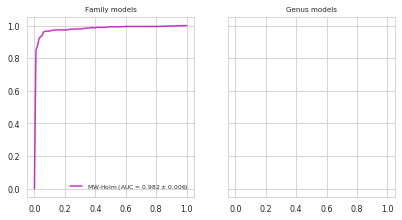

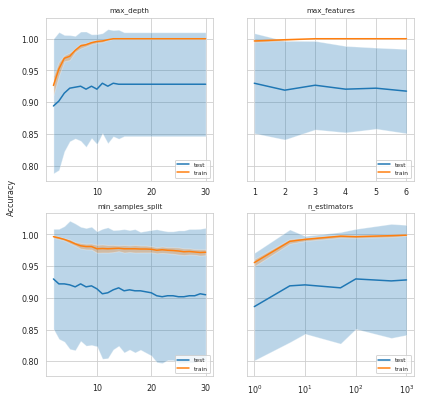

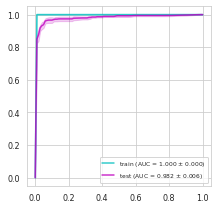

In [91]:
%%time
res = pd.DataFrame()
# levels = [4]
# features = ['best_holm']
# clr_b = [False]
levels = [4,5]
features = ['all','best_fdr','best_holm']
clr_b = [True,False]
fig,axes = plt.subplots(1,2,figsize=(6.6,3.3),sharex=True,sharey=True)
axes[0].set_title('Family models')
axes[1].set_title('Genus models')
ax_dict = {4:axes[0],5:axes[1]}
pdf = fpdf.FPDF()
pdf.set_font("Times", size=12)
for level,feature,clr_b in itertools.product(levels, features, clr_b):
    view_name = shared_functions.view_name(level,feature,clr_b)
    print('Model:',view_name,'(tax level:',shared_functions.get_tax_name_by_level(level),
          '; features:',feature,'; CLR:',clr_b,')')
    f,chao = bf[(level,feature)]
    tf = shared_functions.transformer(bf=f,chao=chao,level=level,clr_b=clr_b)
    taxa_df,chao_df,y = data.get_data_from_ind(dataset_info.index,level,False)
    X = tf.transform_df(taxa_df,chao_df)
    pdf.add_page()
    pdf.cell(180, 10, txt='Model: '+view_name, align="C")
    param_pic_name = os.path.join(pic_dir,'test_params_'+view_name+'.png')
    bp1,bp = test_parameters(X,y,view_name,param_pic_name,pdf)
    pdf.image(param_pic_name, x=20, y=20, w=120)
    pdf.ln(120)
    pdf.set_font("Times", size=10)
    pdf.multi_cell(180, 10, txt="Figure 1. Parameters selection (step 2): Dependancy of accuracy at test (blue) and train (orange) parts of the dataset on the parameter value is shown. The mean+/-standard deviation of 5 folds is shown.", align="L")
    os.remove(param_pic_name)
    #bp = {'max_depth': 11, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}
    pdf.set_font("Times", size=12)
    pdf.multi_cell(180, 10, txt="Best parameters 1:"+str(bp1), align="L")
    pdf.multi_cell(180, 10, txt="Best parameters 2:"+str(bp), align="L")
    rf = ensemble.RandomForestClassifier(random_state=42)
    rf.set_params(**bp)
    name = shared_functions.make_name(level,feature,clr_b,False)
    joblib.dump(rf, os.path.join(joblib_dir,name))
    pdf.ln(65)
    roc_pic_name = os.path.join(pic_dir,'test_roc_'+view_name+'.png')
    res_dict = test_cv5(rf,X,y,view_name,roc_pic_name,ax_dict[level],feature,clr_b,pdf)
    pdf.image(roc_pic_name, x=20, y=175, w=65)
    pdf.set_font("Times", size=10)
    pdf.multi_cell(180, 10, txt="Figure 2. ROC curve at test (magenta) and train (blue) parts of the dataset is shown. The mean+/-standard deviation of 5 folds is shown.", align="L")
    os.remove(roc_pic_name)
    rf.fit(X,y)
    name = shared_functions.make_name(level,feature,clr_b,True)
    joblib.dump(rf, os.path.join(joblib_dir,name))
    oob_res_dict = get_oob_estimate(X,y,bp)
    pdf.set_font("Times", size=12)
    pdf.multi_cell(180, 10, txt='OOB estimations: '+str(oob_res_dict), align="L")
    print(oob_res_dict)
    p = {'name':view_name,'level':shared_functions.get_tax_name_by_level(level),'features':feature,'features_n':X.shape[1],'CLR':clr_b}
    z = {**p, **bp, **res_dict,**oob_res_dict}
    res_i = pd.DataFrame(z,index=[0])
    res = pd.concat([res,res_i])
    print('*****************')
#plt.show()
pdf.output("pics/SupplementaryText1_data.pdf")
fig.savefig('pics/SupplementaryFigure3.pdf', dpi = 300, bbox_inches='tight')
res.to_csv('results/catsNdogs_SupplementaryTable4.txt',sep='\t',index=False)
table2 = res.loc[:,['name','level','features','features_n','CLR','oob_accuracy','oob_f1_score','oob_precision','oob_recall']]
table2.to_csv('results/catsNdogs_Table2.txt',sep='\t',index=False)